In [164]:
#import modules
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML
from lifetimes.plotting import * #need to first install if it not already present by writing pip install lifetimes
from lifetimes.utils import *
from lifetimes.estimation import *

ModuleNotFoundError: No module named 'lifetimes'

In [121]:
df=pd.read_excel('Customer_Analytics.xlsx') 

In [122]:
print(df.head()) #to get the first n rows

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [123]:
df.tail() #to get the last n rows

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [125]:
cols=df.columns
print('ColumnName, DataType, MissingValues')
for i in cols:
    print(i, ',', df[i].dtype,',',df[i].isnull().any())

ColumnName, DataType, MissingValues
InvoiceNo , object , False
StockCode , object , False
Description , object , True
Quantity , int64 , False
InvoiceDate , datetime64[ns] , False
UnitPrice , float64 , False
CustomerID , float64 , True
Country , object , False


In [126]:
df= df[pd.notnull(df['CustomerID'])]

In [127]:
df.info()
print(df['CustomerID'].nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null float64
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB
4372


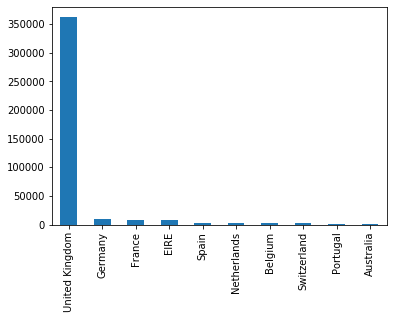

In [128]:
#Top 10 country's customers
df['Country'].value_counts()[:10].plot(kind='bar')

In [129]:
uk_df=df[df.Country=='United Kingdom']
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361878 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      361878 non-null object
StockCode      361878 non-null object
Description    361878 non-null object
Quantity       361878 non-null int64
InvoiceDate    361878 non-null datetime64[ns]
UnitPrice      361878 non-null float64
CustomerID     361878 non-null float64
Country        361878 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB


In [130]:
uk_df.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [131]:
#Filtering negative quantites
uk_df = uk_df[(uk_df['Quantity']>0)]
uk_df.info()
print(uk_df['CustomerID'].nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      354345 non-null object
StockCode      354345 non-null object
Description    354345 non-null object
Quantity       354345 non-null int64
InvoiceDate    354345 non-null datetime64[ns]
UnitPrice      354345 non-null float64
CustomerID     354345 non-null float64
Country        354345 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB
3921


In [132]:
#performing Segmentation using RFM Analysis
#Filtering the required columns
uk_df=uk_df[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

In [133]:
uk_df['TotalPrice'] = uk_df['Quantity'] * uk_df['UnitPrice']

In [134]:
uk_df['InvoiceDate'].min(),uk_df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [135]:
present = dt.datetime(2011,12,10)
uk_df['InvoiceDate'] = pd.to_datetime(uk_df['InvoiceDate'])

In [136]:
uk_df.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [137]:
uk_df.dtypes

CustomerID            float64
InvoiceDate    datetime64[ns]
InvoiceNo              object
Quantity                int64
UnitPrice             float64
TotalPrice            float64
dtype: object

In [138]:
uk_df.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [139]:
rfm= uk_df.groupby('CustomerID').agg({'InvoiceDate': lambda date: (present - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [140]:
rfm.head()

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


In [141]:
rfm.columns

Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')

In [142]:
# Change the name of columns
rfm.columns=['recency','frequency','monetary']

In [143]:
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


In [144]:
rfm['recency'] = rfm['recency'].astype(int)
print(rfm.dtypes)

recency        int32
frequency      int64
monetary     float64
dtype: object


In [145]:
#Computing Quantile of RFM values
#Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])
rfm.head()


,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [146]:
#combing the 3 quartiles for better segmentation
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
print(rfm.head())
print(rfm.dtypes)

            recency  frequency  monetary r_quartile f_quartile m_quartile  \
CustomerID                                                                  
12346.0         325          1  77183.60          4          4          1   
12747.0           2        103   4196.01          1          1          1   
12748.0           0       4596  33719.73          1          1          1   
12749.0           3        199   4090.88          1          1          1   
12820.0           3         59    942.34          1          2          2   

           RFM_Score  
CustomerID            
12346.0          441  
12747.0          111  
12748.0          111  
12749.0          111  
12820.0          122  
recency          int32
frequency        int64
monetary       float64
r_quartile    category
f_quartile    category
m_quartile    category
RFM_Score       object
dtype: object


In [147]:
#top customers
print("The total number of best customers for the store are:",len(rfm[rfm['RFM_Score']=='111']))
print(rfm[rfm['RFM_Score']=='111'].sort_values('monetary', ascending=False).head())

The total number of best customers for the store are: 409
            recency  frequency   monetary r_quartile f_quartile m_quartile  \
CustomerID                                                                   
18102.0           0        431  259657.30          1          1          1   
17450.0           8        337  194550.79          1          1          1   
17511.0           2        963   91062.38          1          1          1   
16684.0           4        277   66653.56          1          1          1   
14096.0           4       5111   65164.79          1          1          1   

           RFM_Score  
CustomerID            
18102.0          111  
17450.0          111  
17511.0          111  
16684.0          111  
14096.0          111  


In [148]:
#Frequent Buyers
rfm[rfm['f_quartile']=='1'].sort_values('frequency', ascending=False).head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
17841.0,1,7847,40991.57,1,1,1,111
14096.0,4,5111,65164.79,1,1,1,111
12748.0,0,4596,33719.73,1,1,1,111
14606.0,1,2700,12156.65,1,1,1,111
15311.0,0,2379,60767.90,1,1,1,111


In [149]:
len(rfm[rfm['f_quartile']=='1'])

980

In [150]:
#customer churn
rfm[rfm['RFM_Score']=='411'].sort_values('monetary', ascending=False).head()
len(rfm[rfm['RFM_Score']=='411'])

20

In [151]:
#k means clustering
#preprocessing the data
rfm_clust=rfm.copy()
scaler=StandardScaler()
rfm_clust_std=scaler.fit_transform(rfm_clust)#standardized data

In [152]:
wcss =[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans.fit(rfm_clust_std)
    wcss.append(kmeans.inertia_)

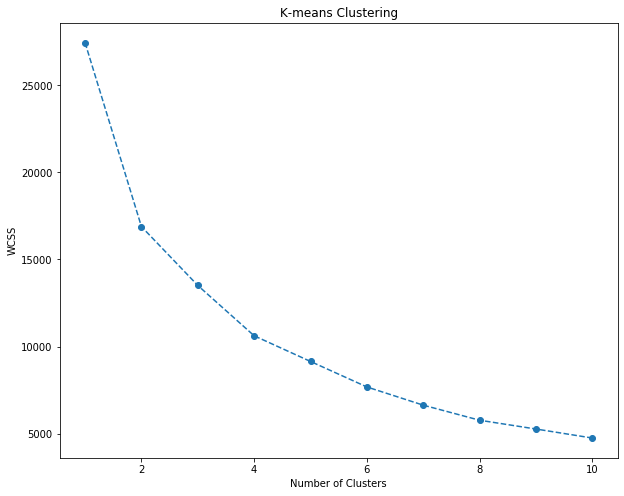

In [153]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11),wcss,marker='o',linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [154]:
kmeans=KMeans(n_clusters=4,init='k-means++',random_state=42)

In [155]:
kmeans.fit(rfm_clust_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [156]:
rfm_kmeans=rfm.copy()
rfm_kmeans['Cluster_No']=kmeans.labels_
rfm_kmeans.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score,Cluster_No
CustomerID,,,,,,,,
12346.0,325,1,77183.60,4,4,1,441,2
12747.0,2,103,4196.01,1,1,1,111,3
12748.0,0,4596,33719.73,1,1,1,111,2
12749.0,3,199,4090.88,1,1,1,111,3
12820.0,3,59,942.34,1,2,2,122,3


In [157]:
rfm_kmeans.loc[rfm_kmeans['RFM_Score'] =='444']

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score,Cluster_No
CustomerID,,,,,,,,
12821.0,214,6,92.72,4,4,4,444,1
12829.0,336,11,293.00,4,4,4,444,1
12831.0,262,9,215.05,4,4,4,444,1
12837.0,173,12,134.10,4,4,4,444,1
12855.0,372,3,38.10,4,4,4,444,1
12881.0,275,7,298.00,4,4,4,444,1
12897.0,204,4,216.50,4,4,4,444,1
12902.0,264,10,138.68,4,4,4,444,1
12929.0,311,8,117.85,4,4,4,444,1


In [158]:
rfm_kmeans.RFM_Score.unique()

array(['441', '111', '122', '444', '322', '341', '333', '133', '231',
       '233', '433', '311', '212', '411', '332', '223', '222', '324',
       '443', '321', '312', '422', '343', '344', '211', '423', '112',
       '243', '142', '234', '121', '442', '221', '131', '134', '334',
       '213', '244', '421', '143', '434', '144', '431', '113', '432',
       '132', '331', '242', '342', '424', '323', '123', '232', '224',
       '124', '412', '241', '313', '413', '141', '114'], dtype=object)

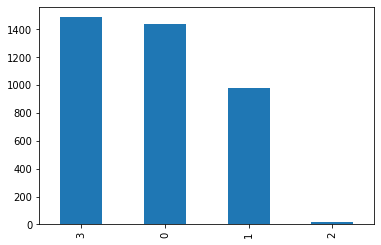

In [159]:
rfm_kmeans['Cluster_No'].value_counts().plot(kind='bar')

In [160]:
#Calculating Customer Lifetime Value
clv=uk_df[['CustomerID','InvoiceDate','TotalPrice']]
clv.head()

,CustomerID,InvoiceDate,TotalPrice
0,17850.0,2010-12-01 08:26:00,15.30
1,17850.0,2010-12-01 08:26:00,20.34
2,17850.0,2010-12-01 08:26:00,22.00
3,17850.0,2010-12-01 08:26:00,20.34
4,17850.0,2010-12-01 08:26:00,20.34


In [161]:
clv['Date'] = clv['InvoiceDate'].dt.date

C:\Users\priya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [162]:
clv1=clv[['CustomerID','Date','TotalPrice']]
clv1.head()

,CustomerID,Date,TotalPrice
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


In [163]:
#to check the Last order date
last_order_date = clv1['Date'].max()
print(last_order_date)
print("--------------------------------------")
print(clv1[(clv1['CustomerID']==12346)])

2011-12-09
--------------------------------------
       CustomerID        Date  TotalPrice
61619     12346.0  2011-01-18     77183.6
